# **Duplicate Question Pairs**

## Data Preprocessing 

In [270]:
# import nltk

# # Download required datasets
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [1]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer


import warnings
warnings.filterwarnings('ignore')


In [2]:
# importing dataset

df = pd.read_csv('questions.csv')

In [3]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
32533,32533,59877,59878,For how long can an infatuation last?,How long does infatuation last?,1
187227,187227,285384,210333,Why do my parents keep calling me a loser?,"What is the actual meaning of ""one shot"" or ""t...",0
172000,172000,265683,265684,What does Shiva's cosmic dance mean?,Is Lord Ganesha a cosmic Leader?,0
226452,226452,335061,335062,What are some reviews of the ApnaCloud cloud s...,What is your review of Cloud Hosting Providers?,0
66954,66954,115956,115957,"What would you prefer, hot water bath in winte...","What does legal term ""acting unreasonably"" mean?",0
35227,35227,64402,64403,How can I end an argument?,How should you end an internet argument?,0
295858,295858,417961,417962,What is subsidy and vat (value added tax)?,What is value added tax?,0
78847,78847,65551,78032,Which is the best way to earn money online in ...,What are the best ways to earn online from india?,1
112249,112249,99983,183691,Does the suggested user list that appears when...,How do I view my Instagram search history?,0
106938,106938,176049,176050,How can I be confident with girls?,How can I be a confident woman?,0


In [4]:
# selecting randomly 50000 rows

new_df = df.sample(5000, random_state=2)
# new_df = new_df.sample(frac=1).reset_index(drop=True)


In [5]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
289024,289024,20941,8014,What should I do in order not to care about wh...,"As an individual, do I really need to care wha...",1
3454,3454,6846,6847,Why AAP’s MLA Dinesh Mohaniya has been arrested?,What are your views on the latest sex scandal ...,0
92547,92547,154928,154929,Requisites to become first time app developer?,What Jobs are available on Cruise Ships for a ...,0
102544,102544,10473,2581,Is it possible to time travel to past?,Is time travel still theorized as being possible?,1
173136,173136,267166,267167,What preparation you should make before gettin...,How should you prepare your body before gettin...,1


In [6]:
new_df.shape

(5000, 6)

In [7]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 289024 to 120403
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   qid1          5000 non-null   int64 
 2   qid2          5000 non-null   int64 
 3   question1     5000 non-null   object
 4   question2     5000 non-null   object
 5   is_duplicate  5000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 273.4+ KB


In [8]:
# checking null values

new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [9]:
new_df.dropna(inplace=True)

In [10]:
# checking duplicate values

new_df.duplicated().sum()

0

In [11]:
# checking values in target variables

print(new_df['is_duplicate'].value_counts())
(new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100

is_duplicate
0    3133
1    1867
Name: count, dtype: int64


is_duplicate
0    62.66
1    37.34
Name: count, dtype: float64

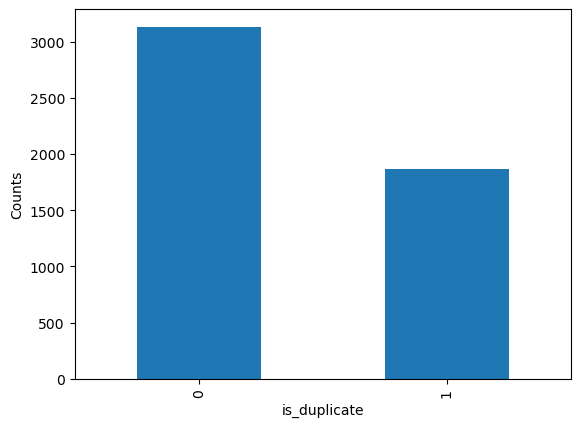

In [12]:
# plotting target values

new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

In [13]:
# data preprocessing

def preprocess(q):
    
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('?', '')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

     # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

        # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [14]:
# applying preprocess

new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [15]:
# applying stemming

ps = PorterStemmer()

def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [16]:
new_df['question1'] = new_df['question1'].apply(stem_words)
new_df['question2'] = new_df['question2'].apply(stem_words)

In [17]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
289024,289024,20941,8014,what should i do in order not to care about wh...,as an individu do i realli need to care what p...,1
3454,3454,6846,6847,whi aap s mla dinesh mohaniya ha been arrest,what are your view on the latest sex scandal b...,0
92547,92547,154928,154929,requisit to becom first time app develop,what job are avail on cruis ship for a b com g...,0
102544,102544,10473,2581,is it possibl to time travel to past,is time travel still theoriz as be possibl,1
173136,173136,267166,267167,what prepar you should make befor get pregnant,how should you prepar your bodi befor get preg...,1


## Feature Engineering

In [18]:
# creating new feature, length of charectors

new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [19]:
# length of questions 

new_df['q1_num_word'] = new_df['question1'].apply(lambda itr: len(itr.split(" ")))
new_df['q2_num_word'] = new_df['question2'].apply(lambda itr: len(itr.split(" ")))

In [20]:
# counting common words in both questions

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [21]:
new_df['common_words'] = new_df.apply(common_words, axis=1)

In [22]:
# counting total words in both questions

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) + len(w2)

In [23]:
new_df['total_words'] = new_df.apply(total_words, axis=1)

In [24]:
# word share = common words in questions/ total words in both questions

new_df['word_share'] = round(new_df['common_words']/new_df['total_words'] + 0.0021, 2)

In [25]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share
289024,289024,20941,8014,what should i do in order not to care about wh...,as an individu do i realli need to care what p...,1,66,65,15,14,9,28,0.32
3454,3454,6846,6847,whi aap s mla dinesh mohaniya ha been arrest,what are your view on the latest sex scandal b...,0,44,69,9,14,2,23,0.09
92547,92547,154928,154929,requisit to becom first time app develop,what job are avail on cruis ship for a b com g...,0,40,52,7,12,0,19,0.00
102544,102544,10473,2581,is it possibl to time travel to past,is time travel still theoriz as be possibl,1,36,42,8,8,4,15,0.27
173136,173136,267166,267167,what prepar you should make befor get pregnant,how should you prepar your bodi befor get preg...,1,46,50,8,9,6,17,0.36


### Creating Advanced Features

In [26]:
# features based on tokens

def token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    safe_div = 0.0001

    token_features = [0.0]*8

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    stopword = stopwords.words('english')

    q1_non_stopwords = set([word for word in q1_tokens if word not in stopword])
    q2_non_stopwords = set([word for word in q2_tokens if word not in stopword])

    q1_stop_words = set([word for word in q1_tokens if word in stopword]) 
    q2_stop_words = set([word for word in q2_tokens if word in stopword]) 

    common_word_count = len(q1_non_stopwords.intersection(q2_non_stopwords))
    common_stop_word_count = len(q1_stop_words.intersection(q2_stop_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count/(min(len(q1_non_stopwords), len(q2_non_stopwords)) + safe_div)
    token_features[1] = common_word_count/(max(len(q1_non_stopwords), len(q2_non_stopwords)) + safe_div)
    token_features[2] = common_stop_word_count/(min(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[3] = common_stop_word_count/(max(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[4] = common_token_count/(min(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[5] = common_token_count/(max(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [27]:
token_features = new_df.apply(token_features, axis=1)

new_df['cwc_min'] = list(map(lambda x:x[1], token_features))
new_df['cwc_max'] = list(map(lambda x:x[0], token_features))
new_df['csc_min'] = list(map(lambda x:x[2], token_features))
new_df['csc_max'] = list(map(lambda x:x[3], token_features))
new_df['ctc_min'] = list(map(lambda x:x[4], token_features))
new_df['ctc_max'] = list(map(lambda x:x[5], token_features))
new_df['last_word_eq'] = list(map(lambda x:x[6], token_features))
new_df['first_word_eq'] = list(map(lambda x:x[7], token_features))

In [28]:
# # length features

# import distance

# def length_features(row):

#     length_features = [0.0]*3

#     q1 = row['question1']
#     q2 = row['question2']

#     q1_tokens = q1.split()
#     q2_tokens = q2.split()

#     length_features[0] = (len(q1_tokens) + len(q2_tokens))/2
#     length_features[1] = abs(len(q1_tokens) - len(q2_tokens))
#     strs = list(distance.lcsubstrings(q1, q2))
#     if len(strs):
#         length_features[2] = len(strs[0])/(min(len(q1), len(q2)) + 1)
#     else:
#         length_features[2] = 0   

#     return length_features



In [29]:
# length_features = new_df.apply(length_features, axis=1)

# new_df['mean_length'] = list(map(lambda x:x[0], length_features))
# new_df['abs_length_diff'] = list(map(lambda x:x[1], length_features))
# new_df['longest_substring_ratio'] = list(map(lambda x:x[2], length_features))

In [30]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [31]:
fuzzy_features = new_df.apply(fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

## EDA on newly created features

In [245]:
new_df.shape

(30000, 25)

In [246]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
289024,289024,20941,8014,what should i do in order not to care about wh...,as an individu do i realli need to care what p...,1,66,65,15,14,9,28,0.32,0.499992,0.749981,0.749991,0.599994,0.642853,0.599996,1,0,67,68,70,77
3454,3454,6846,6847,whi aap s mla dinesh mohaniya ha been arrest,what are your view on the latest sex scandal b...,0,44,69,9,14,2,23,0.09,0.249997,0.285710,0.000000,0.000000,0.222220,0.142856,0,0,35,49,41,48
92547,92547,154928,154929,requisit to becom first time app develop,what job are avail on cruis ship for a b com g...,0,40,52,7,12,0,19,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,35,42,30,30
102544,102544,10473,2581,is it possibl to time travel to past,is time travel still theoriz as be possibl,1,36,42,8,8,4,15,0.27,0.599988,0.749981,0.333322,0.333322,0.499994,0.499994,0,1,51,53,56,80
173136,173136,267166,267167,what prepar you should make befor get pregnant,how should you prepar your bodi befor get preg...,1,46,50,8,9,6,17,0.36,0.799984,0.799984,0.666644,0.499988,0.749991,0.666659,1,0,73,78,79,88


Minimul length of question is  2
Maximum length of question is  284
Average length of question is  53.66


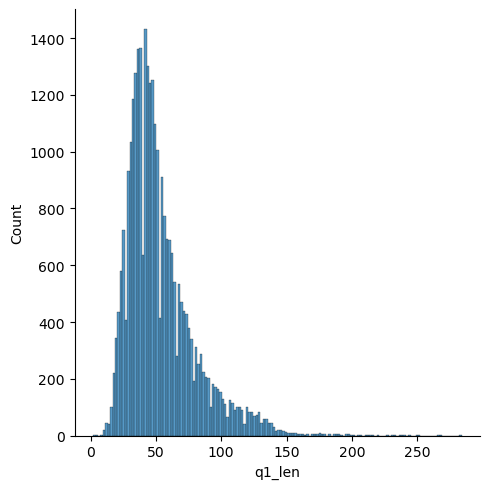

In [247]:
# distribution of length of question_1

sns.displot(new_df['q1_len'])
print('Minimul length of question is ', new_df['q1_len'].min())
print('Maximum length of question is ', new_df['q1_len'].max())
print('Average length of question is ', round(new_df['q1_len'].mean(), 2))

Minimul length of question is  5
Maximum length of question is  1086
Average length of question is  54 2


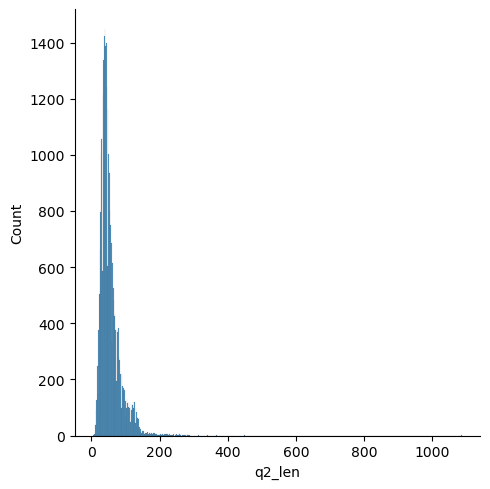

In [248]:
# distribution of length of question_2

sns.displot(new_df['q2_len'])
print('Minimul length of question is ', new_df['q2_len'].min())
print('Maximum length of question is ', new_df['q2_len'].max())
print('Average length of question is ', round(new_df['q2_len'].mean()), 2)

Minimul words in question_1 is  1
Maximum words in question_1 is  59
Average words in question_1 is  11.09


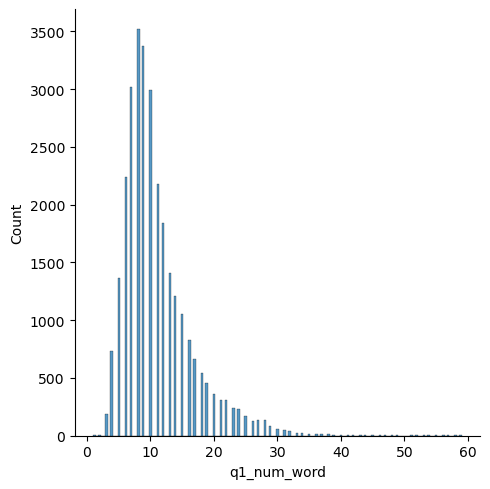

In [249]:
# distribution of number of number of words in question_1

sns.displot(new_df['q1_num_word'])
print('Minimul words in question_1 is ', new_df['q1_num_word'].min())
print('Maximum words in question_1 is ', new_df['q1_num_word'].max())
print('Average words in question_1 is ', round(new_df['q1_num_word'].mean(), 2))

Minimul words in question_2 is  1
Maximum words in question_2 is  248
Average words in question_2 is  11.39


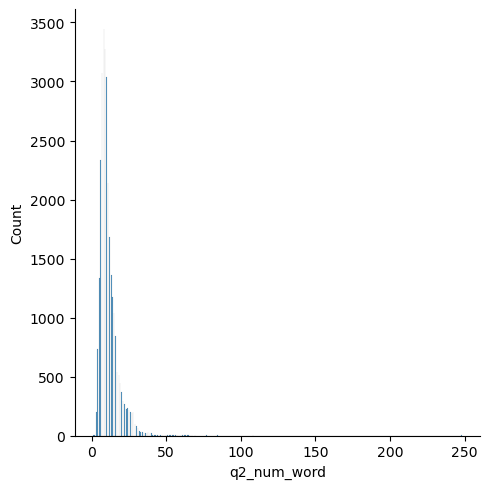

In [250]:
# distribution of number of words in quesion_2

sns.displot(new_df['q2_num_word'])
print('Minimul words in question_2 is ', new_df['q2_num_word'].min())
print('Maximum words in question_2 is ', new_df['q2_num_word'].max())
print('Average words in question_2 is ', round(new_df['q2_num_word'].mean(), 2))

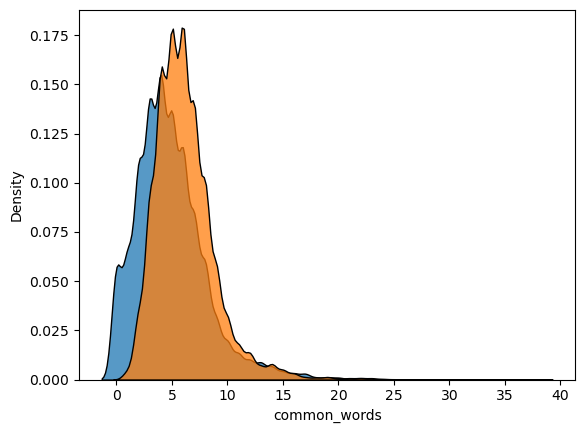

In [251]:
# kde plot of common words 

sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['common_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['common_words'], legend=True, multiple='stack')
plt.show()

In [134]:
# observations

# in above plot we can see that as number of common words increases, probability for duplicate question pair increases 

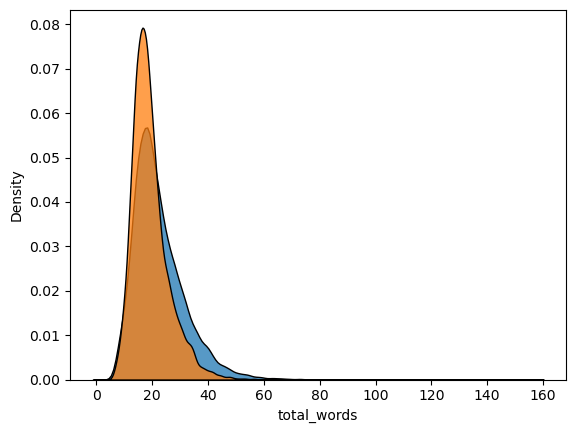

In [135]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['total_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['total_words'], legend=True, multiple='stack')
plt.show()

In [136]:
# observations

# as total words increases probability for question pair is not duplicate increases

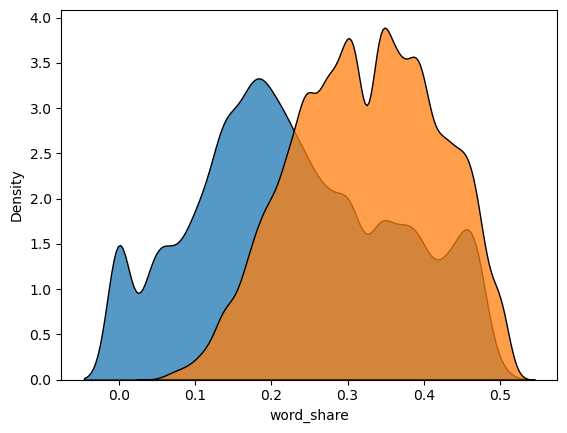

In [137]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['word_share'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['word_share'], legend=True, multiple='stack')
plt.show()

In [138]:
# observations

# as word share increases, probability of duplicate question pair increases

In [139]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_word', 'q2_num_word', 'common_words',
       'total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

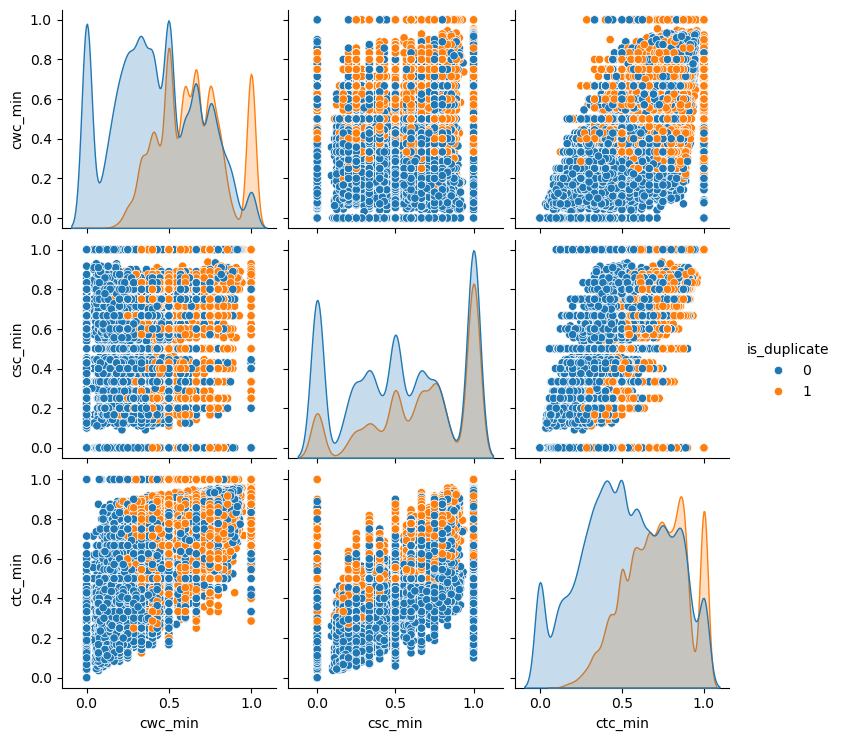

In [140]:
sns.pairplot(new_df[['cwc_min', 'csc_min', 'ctc_min', 'is_duplicate']], hue='is_duplicate')

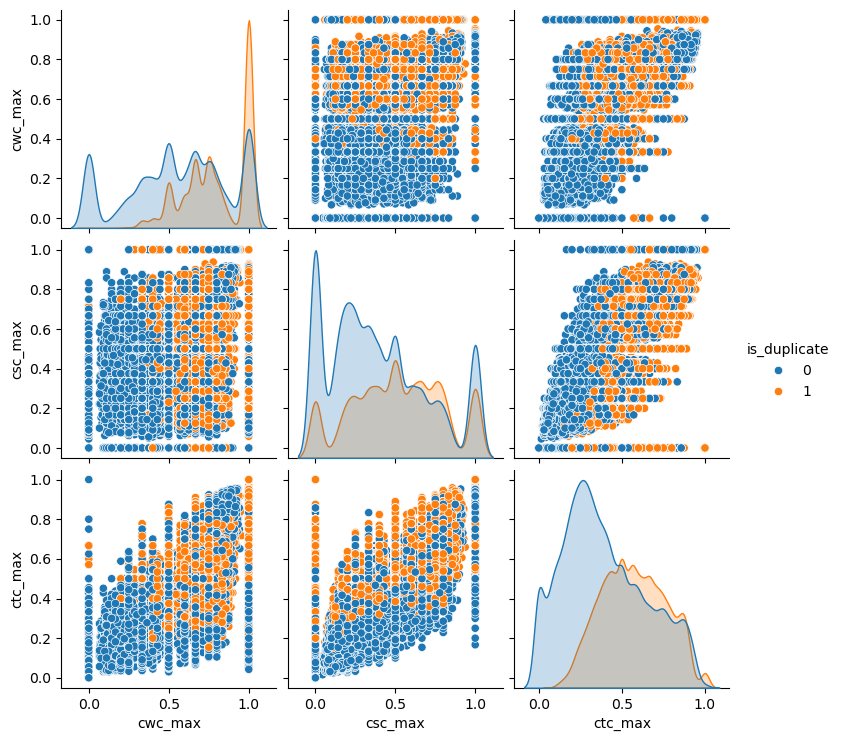

In [141]:
sns.pairplot(new_df[['cwc_max', 'csc_max', 'ctc_max', 'is_duplicate']], hue='is_duplicate')

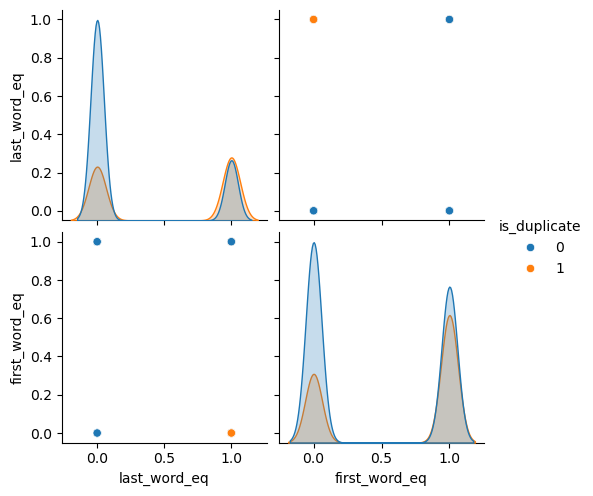

In [142]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

In [145]:
# sns.pairplot(new_df[['mean_length','abs_length_diff', 'longest_substring_ratio', 'is_duplicate']], hue='is_duplicate')

In [146]:
# from above plots we can see that length features are not that much helpful

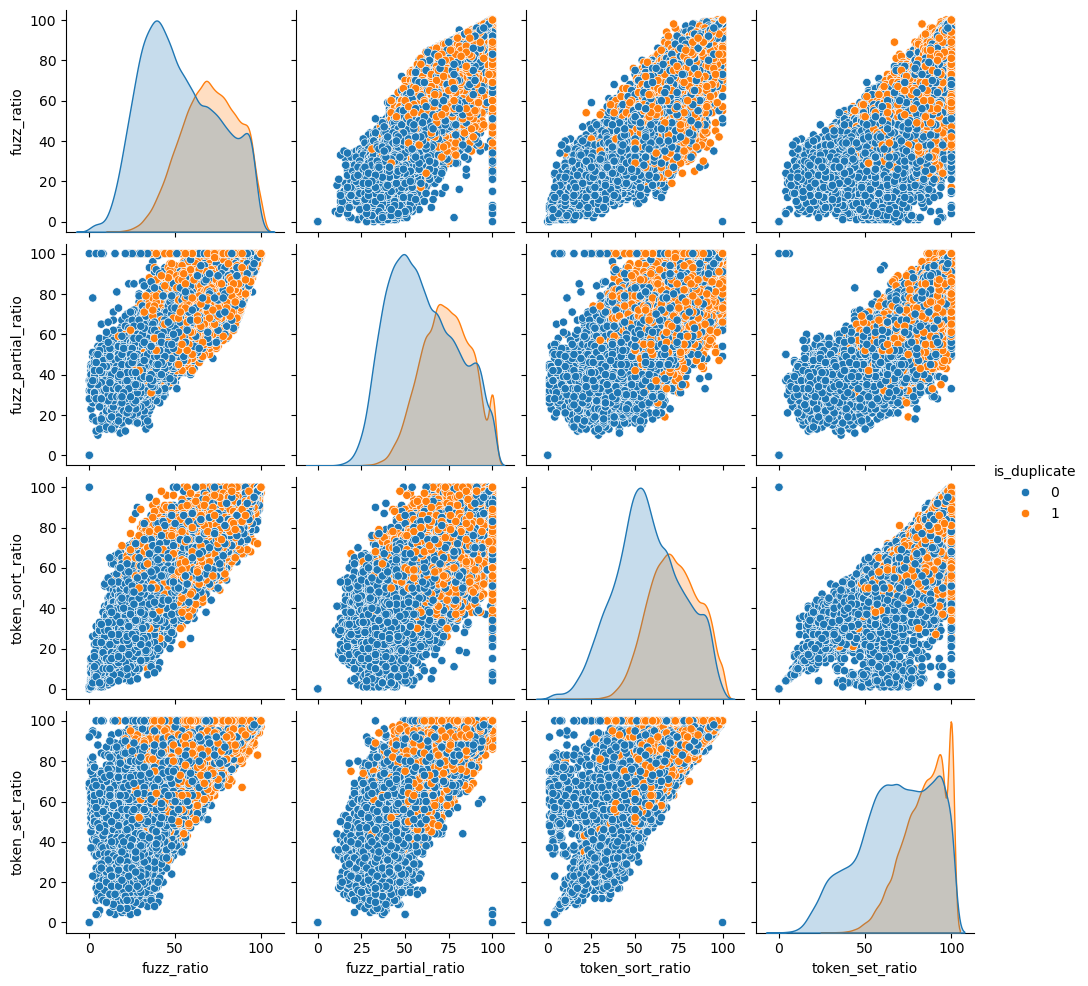

In [147]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')

## TF-IDF weighted word2vec

In [32]:
# creating word2vec representation of words

# creating a list of all questions
questions = list(new_df['question1']) + list(new_df["question2"])

tokenized_docs = [word_tokenize(doc.lower()) for doc in questions]
word2vec_model = Word2Vec(window=11, min_count=1, workers=4)

word2vec_model.build_vocab(tokenized_docs)
word2vec_model.train(tokenized_docs, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)
 

(399992, 564000)

In [33]:
# Compute TF-IDF scores

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(questions)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = dict(zip(tfidf_feature_names, tfidf_matrix.toarray().sum(axis=0)))

In [34]:
# function which return tfidf average word2vec for a document

def tfidf_weighted_word2vec(doc, word2vec_model, tfidf_scores):
    word_vectors = []
    for word in doc:
        if word in word2vec_model.wv.key_to_index:
            # Get the Word2Vec vector for the word
            vector = word2vec_model.wv[word]
            # Multiply by the TF-IDF score for the word
            tfidf_score = tfidf_scores.get(word, 0.0)
            weighted_vector = vector * tfidf_score
            word_vectors.append(weighted_vector)
    
    # Compute the weighted average of the word vectors
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


In [35]:
# applying above function

half = len(tokenized_docs) // 2

q1_docs = tokenized_docs[:half]
q2_docs = tokenized_docs[half:]

q1_arr = np.array([tfidf_weighted_word2vec(doc, word2vec_model, tfidf_scores) for doc in q1_docs])
q2_arr = np.array([tfidf_weighted_word2vec(doc, word2vec_model, tfidf_scores) for doc in q2_docs])

In [36]:
# creating dataframe for tfidf weighted word2vec representation of text

temp1 = pd.DataFrame(q1_arr, index=new_df.index)
temp2 = pd.DataFrame(q2_arr, index=new_df.index)

temp_df = pd.concat([temp1, temp2], axis=1)

temp_df.shape

(5000, 200)

In [37]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_word', 'q2_num_word', 'common_words',
       'total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [38]:
# dropping unwanted columns

new_df.drop(columns = ['id', 'qid1', 'qid2', 'question1', 'question2'], inplace=True)

In [39]:
# main dataframe which is to be given to model

main_df = pd.concat([new_df, temp_df], axis=1)

In [40]:
main_df.shape

(5000, 220)

In [41]:
main_df.head()

,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share,cwc_min,cwc_max,...,90,91,92,93,94,95,96,97,98,99
289024,1,66,65,15,14,9,28,0.32,0.499992,0.749981,...,106.845589,31.153509,-16.130854,39.415230,163.185028,74.767822,43.927803,-84.239174,27.504545,-40.269650
3454,0,44,69,9,14,2,23,0.09,0.249997,0.285710,...,117.680199,11.975741,9.582751,59.020359,155.766357,73.167961,31.420797,-99.066895,7.849059,-26.267529
92547,0,40,52,7,12,0,19,0.00,0.000000,0.000000,...,102.801727,13.206578,3.107312,46.153549,133.210800,61.519703,31.781647,-84.981956,13.914355,-24.289482
102544,1,36,42,8,8,4,15,0.27,0.599988,0.749981,...,83.875259,18.350985,2.104257,44.385635,132.521011,67.555466,35.983360,-70.914688,14.224821,-35.118511
173136,1,46,50,8,9,6,17,0.36,0.799984,0.799984,...,101.938644,52.306854,-41.791920,29.770195,176.478561,78.541443,49.355106,-76.468269,39.393295,-51.546284


## Model Building 

In [42]:
# seperating dataset into X and y

X = main_df.drop(columns=['is_duplicate']).values
y = main_df['is_duplicate'].values

In [48]:
# splitting dataset for training and testing 

from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)



In [44]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state = 12)

# X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [52]:
# random forest classifier model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rfc = RandomForestClassifier(random_state=42)
 
rfc.fit(X_train, y_train)
 
rfc_y_pred = rfc.predict(X_test)

print('Accuracy of Random Forest Classifier is ', accuracy_score(y_test, rfc_y_pred))

print(confusion_matrix(y_test, rfc_y_pred))

report = classification_report(y_test, rfc_y_pred)

print(report)



Accuracy of Random Forest Classifier is  0.7232
[[623 138]
 [208 281]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       761
           1       0.67      0.57      0.62       489

    accuracy                           0.72      1250
   macro avg       0.71      0.70      0.70      1250
weighted avg       0.72      0.72      0.72      1250



In [53]:
param_dist = {
    'n_estimators': np.arange(10, 200, 10),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': np.arange(5, 30, 5),  # Maximum number of levels in tree
    'min_samples_split': np.arange(2, 10, 2),  # Minimum number of samples required to split a node
    'min_samples_leaf': np.arange(1, 5),  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Step 5: Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist,
                               n_iter=200, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Step 6: Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Step 7: Print the best parameters found
print("Best parameters found: ", rf_random.best_params_)

# Step 8: Predict and evaluate the model on test set using the best estimator
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [ ]:
# xgbclassifier model

from xgboost import XGBClassifier

 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
 
xgb.fit(X_train, y_train)
 
xgb_y_pred = xgb.predict(X_test)


print('Accuracy for xgboost is ', accuracy_score(y_test, xgb_y_pred))

print(confusion_matrix(y_test, xgb_y_pred))

report = classification_report(y_test, xgb_y_pred)

print(report)


Accuracy for xgboost is  0.7208
[[601 160]
 [189 300]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       761
           1       0.65      0.61      0.63       489

    accuracy                           0.72      1250
   macro avg       0.71      0.70      0.70      1250
weighted avg       0.72      0.72      0.72      1250



In [ ]:
param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10, 1),  # Maximum depth of the trees
    'learning_rate': np.arange(0.01, 0.2, 0.01),  # Step size shrinkage
    'subsample': np.arange(0.6, 1.0, 0.1),  # Subsample ratio of the training instances
    'colsample_bytree': np.arange(0.6, 1.0, 0.1),  # Subsample ratio of columns when constructing each tree
    'gamma': np.arange(0, 5, 0.5),  # Minimum loss reduction required to make a further partition
    'reg_alpha': np.logspace(-4, 0, 10),  # L1 regularization term on weights
    'reg_lambda': np.logspace(-4, 0, 10),  # L2 regularization term on weights
}

# Step 5: Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                n_iter=200, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Step 6: Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Step 7: Print the best parameters found
print("Best parameters found: ", xgb_random.best_params_)

# Step 8: Predict and evaluate the model on test set using the best estimator
best_xgb = xgb_random.best_estimator_
y_pred = best_xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 0.7999999999999999, 'reg_lambda': 0.016681005372000592, 'reg_alpha': 0.12915496650148828, 'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.09999999999999999, 'gamma': 3.5, 'colsample_bytree': 0.6}
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80       761
           1       0.69      0.63      0.66       489

    accuracy                           0.74      1250
   macro avg       0.73      0.72      0.73      1250
weighted avg       0.74      0.74      0.74      1250



In [266]:
# Both models random forest classifier and xgboost performing nearly same, 
# since I have to reduce false negative i.e. typeI error I will go with Random Forest Classifier

In [267]:
# # naive bayes classifier

# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# gnb.fit(X_train, y_train)

# gnb_y_pred = gnb.predict(X_test)
# print('Accuracy of GaussianNB is ', accuracy_score(gnb_y_pred, y_test))
# confusion_matrix(gnb_y_pred, y_test)


In [268]:
# from sklearn.svm import SVC

# svc = SVC()
# svc.fit(X_train, y_train)

# svc_y_pred = svc.predict(X_test)
# print('Accuracy of SVC is ', accuracy_score(svc_y_pred, y_test))
# confusion_matrix(svc_y_pred, y_test)


In [317]:
# import pickle

# with open ('model.pkl', 'wb') as file1:
#     pickle.dump(xgb, file1)

# with open('tfidf_vectorizer.pkl', 'wb') as file2:
#     pickle.dump(tfidf_vectorizer, file2)

# word2vec_model.save('word2vec_model.model')
      

In [318]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler

In [342]:
sc = StandardScaler()

X_train_1 = sc.fit_transform(X_train)

In [356]:
model = Sequential()

model.add(Dense(256, input_shape=(219, ), activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

In [357]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               56320     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_16 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 64)               

In [358]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy', Precision(), Recall()])

In [359]:
history = model.fit(X_train_1, y_train, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 10s 4ms/step - loss: 0.5395 - accuracy: 0.6995 - precision_4: 0.5893 - recall_4: 0.6157 - val_loss: 0.4764 - val_accuracy: 0.7495 - val_precision_4: 0.6448 - val_recall_4: 0.7029
Epoch 2/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.5006 - accuracy: 0.7307 - precision_4: 0.6329 - recall_4: 0.6451 - val_loss: 0.4757 - val_accuracy: 0.7466 - val_precision_4: 0.6354 - val_recall_4: 0.7223
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4889 - accuracy: 0.7408 - precision_4: 0.6473 - recall_4: 0.6550 - val_loss: 0.4611 - val_accuracy: 0.7601 - val_precision_4: 0.6588 - val_recall_4: 0.7148
Epoch 4/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4826 - accuracy: 0.7445 - precision_4: 0.6516 - recall_4: 0.6622 - val_loss: 0.4599 - val_accuracy: 0.7573 - val_precision_4: 0.6551 - val_recall_4: 0.7116
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/

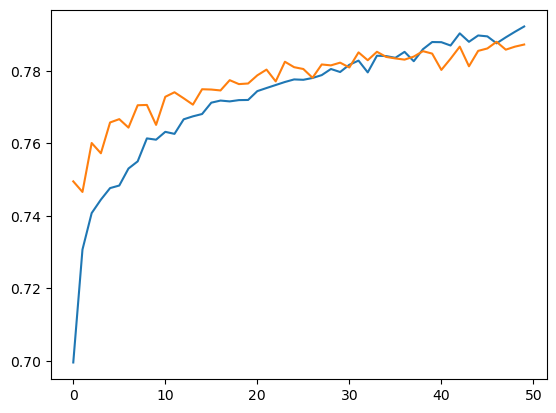

In [360]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

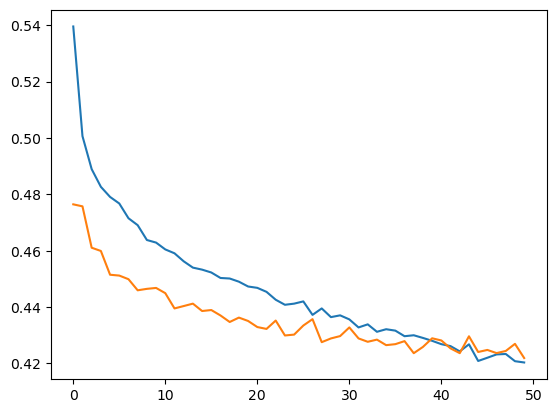

In [361]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [371]:
from sklearn.metrics import roc_curve, auc

In [372]:
X_test_1 = sc.transform(X_test)

In [373]:
dl_y_prob = model.predict(X_test_1)

625/625 [==============================] - 1s 2ms/step


In [377]:
fpr, tpr, thresholds = roc_curve(y_test, dl_y_prob)
roc_auc = auc(fpr, tpr)

print(thresholds)

[          inf 9.9422997e-01 9.7573167e-01 ... 1.3863688e-02 1.3850721e-02
 5.0661478e-05]


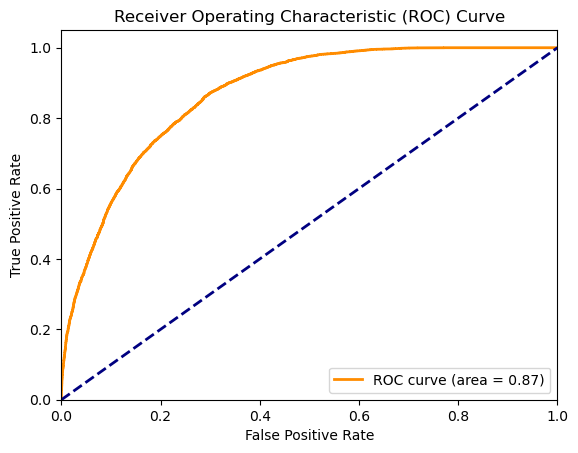

In [376]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [375]:
dl_y_pred = (dl_y_prob >= 0.5).astype(int)
print(accuracy_score(y_test, dl_y_pred))
print(classification_report(y_test, dl_y_pred))

0.7856
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12657
           1       0.72      0.69      0.70      7343

    accuracy                           0.79     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.78      0.79      0.78     20000



In [378]:
dl_y_pred, y_test

(array([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]),
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64))

In [380]:
X_test[0]

array([ 5.10000000e+01,  3.60000000e+01,  1.30000000e+01,  1.00000000e+01,
        7.00000000e+00,  2.30000000e+01,  3.10000000e-01,  7.14275510e-01,
        9.99980000e-01,  3.99992000e-01,  3.33327778e-01,  6.99993000e-01,
        5.38457396e-01,  1.00000000e+00,  0.00000000e+00,  7.10000000e+01,
        8.10000000e+01,  6.90000000e+01,  8.60000000e+01,  2.36753723e+02,
        8.29731323e+02,  1.35239966e+03, -2.29081860e+03,  3.44429993e+02,
       -2.37052597e+02, -2.20561096e+02, -1.45719519e+03,  2.35255298e+03,
       -8.26522888e+02,  9.56670898e+02, -1.75485321e+02, -2.18679004e+03,
        3.36047876e+03, -1.20019348e+03, -1.30879248e+03,  2.72497803e+03,
       -2.22411182e+03,  1.54927368e+03, -2.15058154e+03,  1.22404015e+02,
        1.11092554e+03, -4.90400909e+02,  1.04016785e+03, -1.18256982e+03,
       -2.86725616e+02,  3.50383984e+03,  6.08541077e+02, -9.57754944e+02,
       -8.26885376e+02,  1.13272351e+03,  1.12306763e+03, -3.77075366e+03,
       -8.15279175e+02,  

In [365]:
model.save('dl_model.h5')

In [ ]:
# our best model is deep learning model so we will go with our deep learning model.